In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# set the colormap and centre the colorbar
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [5]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


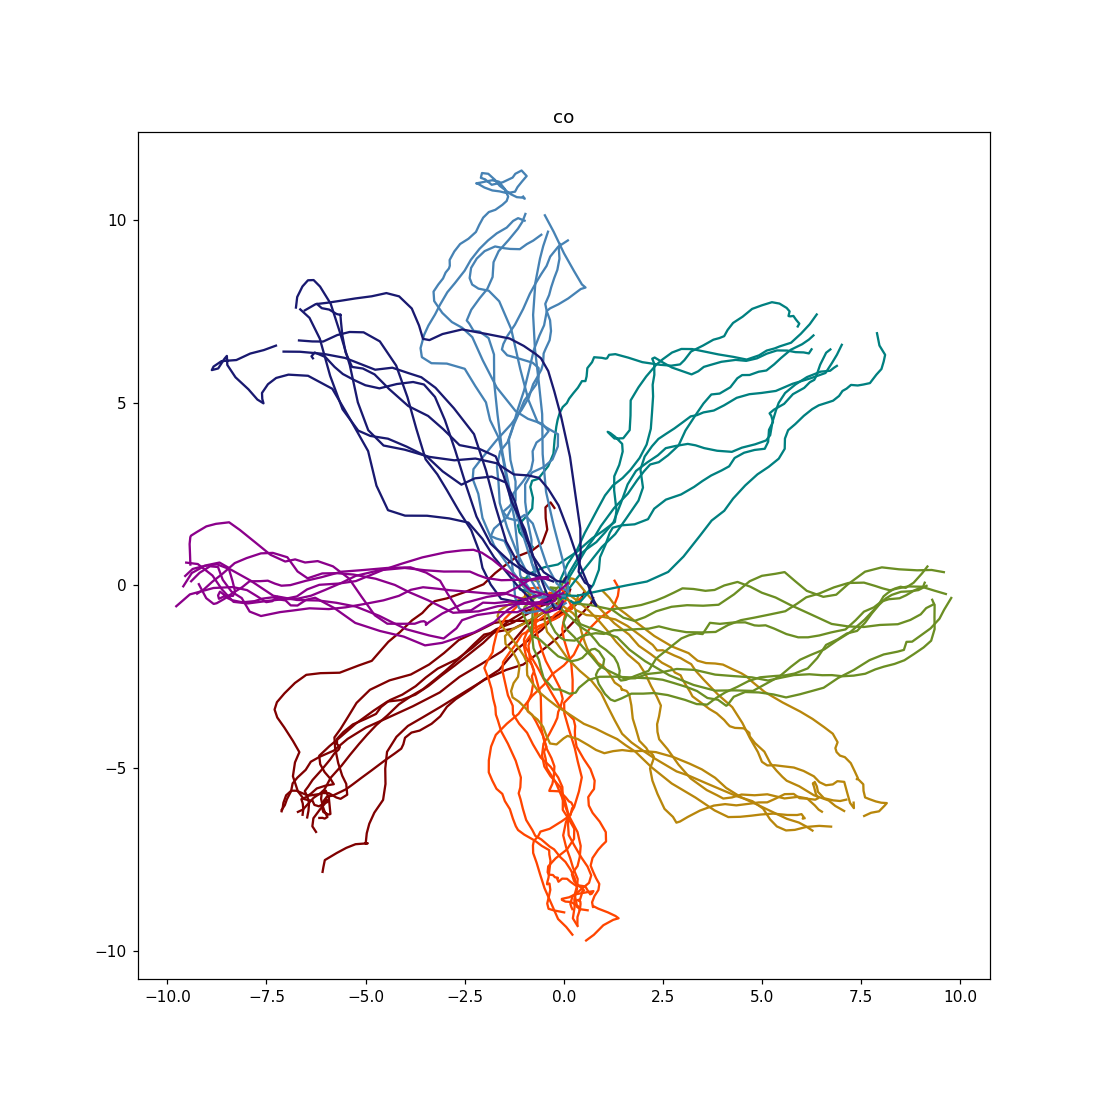

<IPython.core.display.Javascript object>


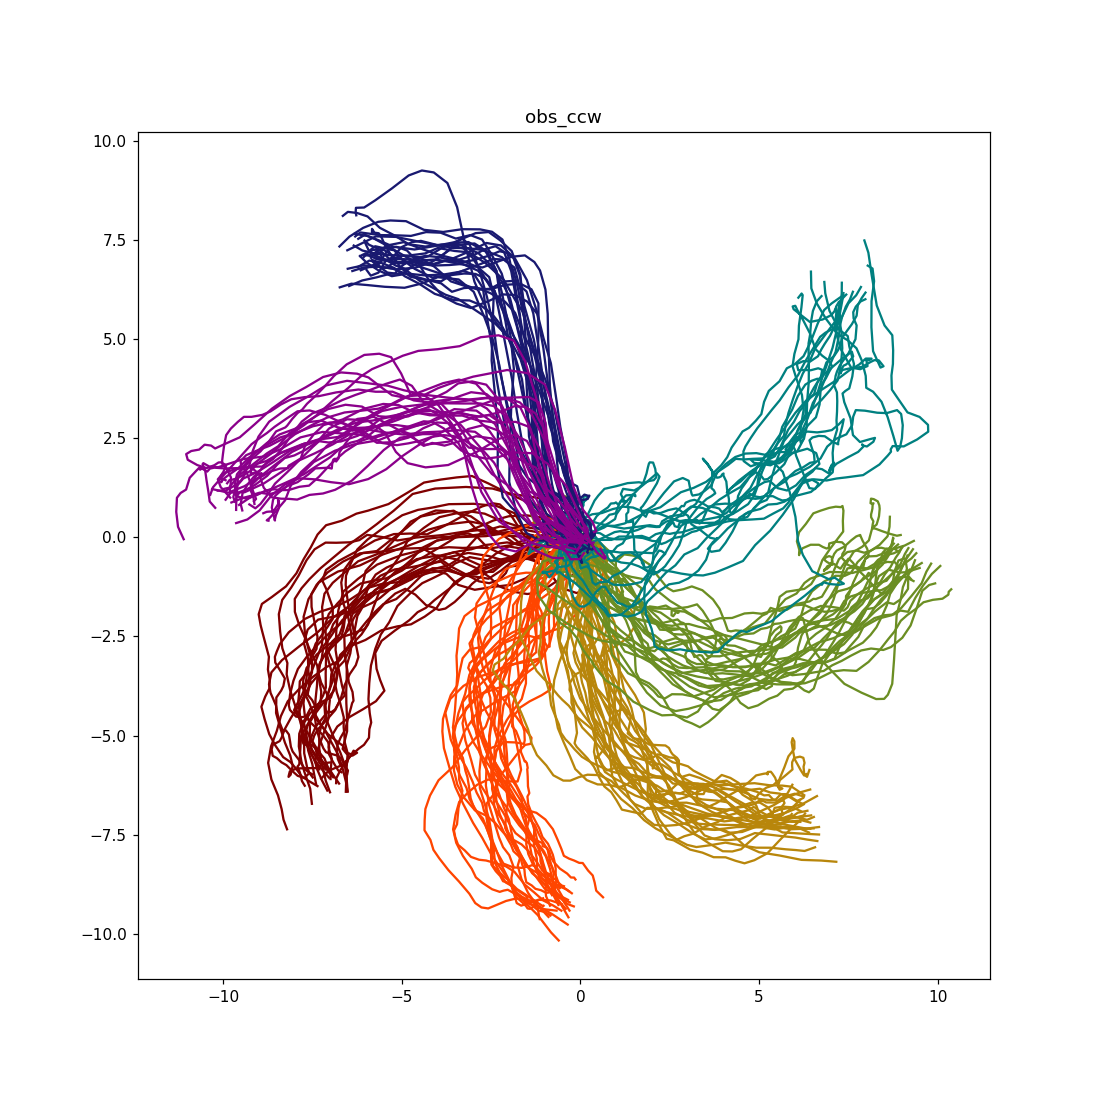

<IPython.core.display.Javascript object>


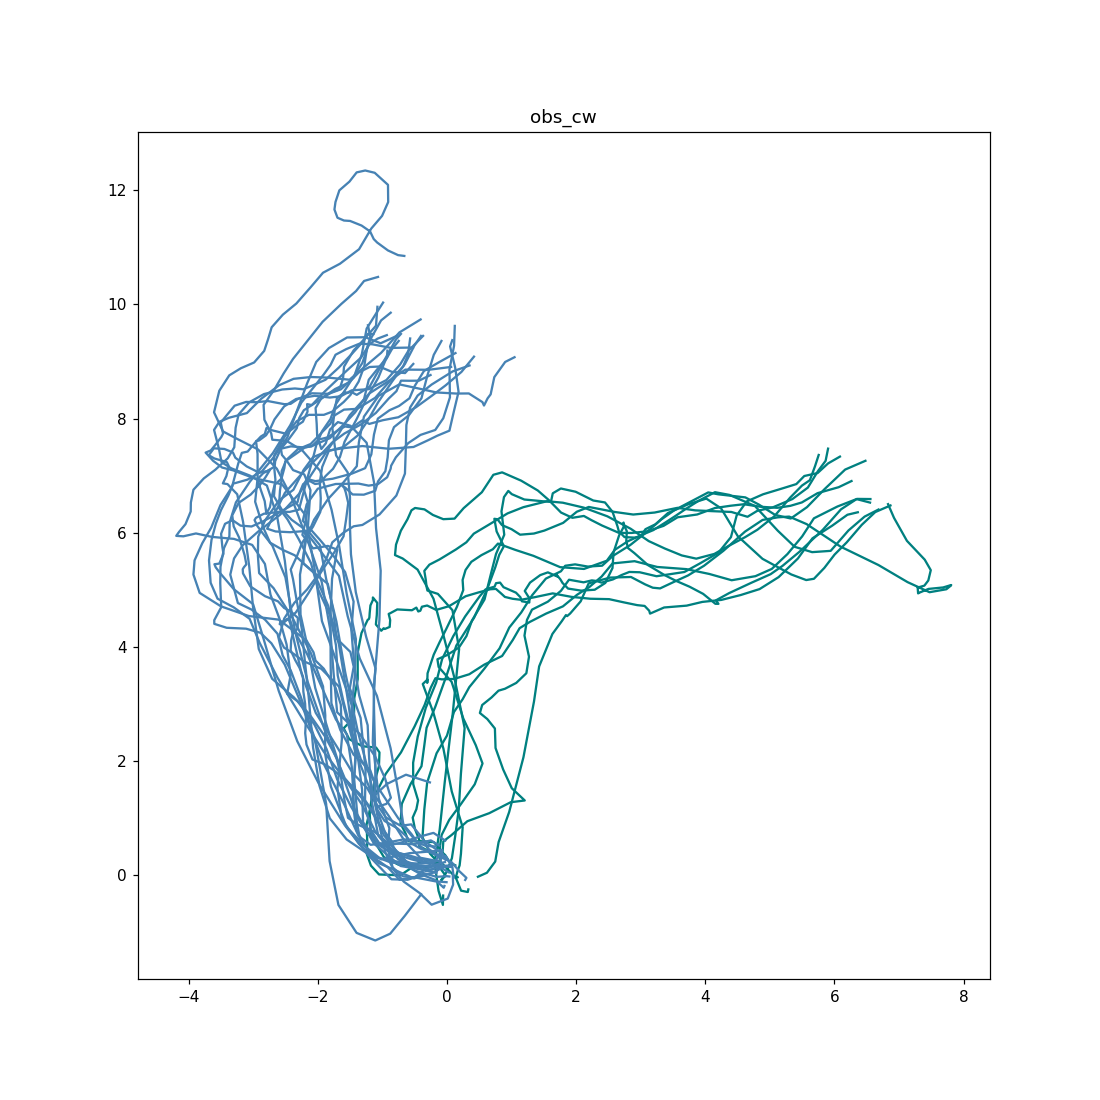

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


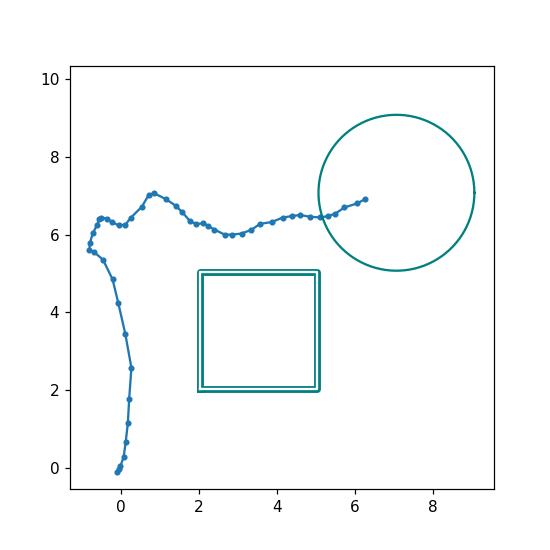

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [7]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

In [42]:
del df

### Load simulation and analysis: 

In [11]:
a = 'grom'
d = str(0)
save_home = r'D:\DATA\bmi_co_obs_backup'
load_dir = os.path.join(save_home, a, str(d))

In [9]:
load_path = os.path.join(load_dir, 'lqr_init_fp_full_noisy.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
    
for (k,v) in r.items():
    exec(k+'=v')
df_lqr = df_lqr_n

In [14]:
print(r.keys())

['state_dim', 'num_neurons', 'Qv_s', 'norm_u_df_nl', 'noise_dic', 'num_offset', 'A_dic', 'num_trials', 'input_label', 'obs_margin', 'Qfp_s', 'Q_f', 'state_label', 'move_lqr_nl', 'kin_var', 'num_kin', 'Qfv_s', 'bn_m', 'df_lqr_nl', 'df_lqr_n', 'B', 'task_rot_list', 'F', 'n_init_dic', 'R_s', 'Kn', 'Q', 'target_list', 'R', 'offset_var', 'waypoint_speed', 'An_m', 'A_list', 'center', 'model_list', 'move_lqr_n', 'norm_u_df_n', 'Qp_s', 'm_noise', 'n_list', 'move_horizon']


In [12]:
#Load the analysis too: 

#analyze neural diff: 
p_sig_match = 0.05
shuffle_bool = True
num_shuffle = 1000 #10 #1000
min_obs = 15
num_trials = 20

#Save information
load_file = \
'analysis_v2.1_lqr_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'

#Load all session's results
load_path = os.path.join(load_dir, load_file)
with open(load_path, 'rb') as f: 
    r_1 = pickle.load(f)     
for (k,v) in r_1.items():
    exec(k+'=v')
    

In [13]:
print(r_1.keys())

['p_sig_match', 'task_rot_list', 'num_neurons', 'num_targets', 'num_shuffle', 'model_cm', 'num_mag_bins_analyze', 'r_u', 'num_angle_bins', 'Kn', 'model_diff', 'norm_u_df_n', 'min_obs', 'shuffle_bool', 'r_n', 'm_list', 'n_list', 'c_list']


### Plot single trials of movement

In [16]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\lqr'

In [23]:
fig_name

'n_do_grom_0_3ex_trials'

<IPython.core.display.Javascript object>


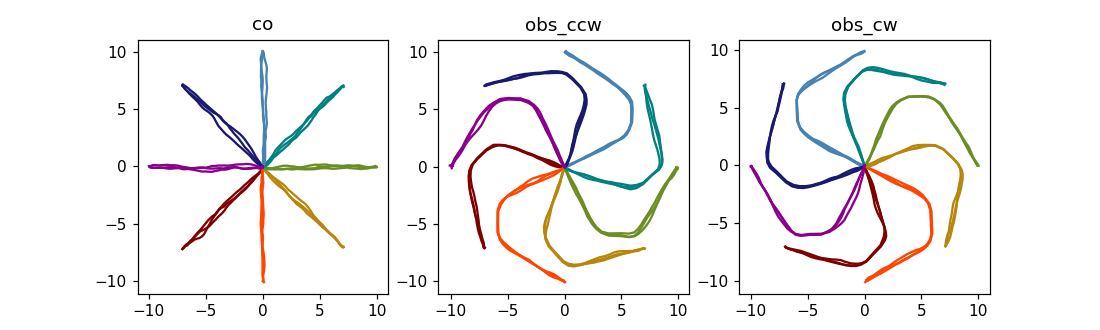

In [25]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_o'
num_trials_plot = 3
save_bool = True
fig_name = m+'_'+a+'_'+str(d)+'_' + str(num_trials_plot)+ 'ex_trials'

plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']


plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)
            
if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))            

### Plot example command

In [26]:
model_cm.keys()

[(('decoder_null', 'n_do'), (2, 4), (6, 1.1), 'cm_idx'),
 (('full', 'n_do'), (0, 4), (4, 0), 'n_diff_norm_mean', 's', 'null'),
 (('decoder_null', 'n_do'), (0, 7), (0, 1.2), 'n_diff', 'obs', 'null'),
 (('decoder_null', 'n_do'), (0, 5), (5, 1.1), 'n_diff_norm', 'obs', 'null'),
 (('full', 'n_o'), (3, 5), (6, 0), 'n_diff_norm_mean', 's', 'null'),
 (('full', 'n_do'), (1, 1), (5, 1.2), 'sel'),
 (('full', 'n_do'), (1, 5), (6, 1.1), 'n_diff', 's', 'null'),
 (('decoder_null', 'n_do'), (1, 2), (2, 1.2), 'num_obs'),
 (('full', 'n_o'), (3, 1), (6, 1.1), 'n_diff_norm_mean', 's', 'potent'),
 (('decoder_null', 'n_do'), (1, 7), (2, 1.2), 'n_diff_norm_std', 's', 'null'),
 (('decoder_null', 'n_do'), (2, 2), (1, 1.2), 'n_cm'),
 (('full', 'n_do'), (2, 6), (1, 1.2), 'pool_match_ttest'),
 (('decoder_null', 'n_do'), (2, 0), (7, 1.2), 'sel'),
 (('full', 'n_o'), (3, 4), (1, 0), 'n_diff_norm', 's', 'null'),
 (('decoder_null', 'n_o'), (0, 5), (6, 1.1), 'n_s'),
 (('decoder_null', 'n_do'), (0, 6), (3, 1.2), 'n_s')

In [36]:
#Given a command, ask how many observations are there for a bunch of conditions.

In [80]:
#For a given command, find conditions that have greater than 'min_obs' observations, 
c = (2,1)
model_list_analyze = [('full', 'n_do'), ('full', 'n_o')]
min_obs = 15
m_for_c = []


    
for m in m_list:
    include_m = True
    for model in model_list_analyze:
        num_obs = model_cm[model, c, m, 'num_obs']
        #print(m, num_obs)
        if num_obs < min_obs:
            include_m = False
    if include_m:
        m_for_c.append(m)
        

In [82]:
m_for_c

[(0, 1.1), (0, 1.2), (1, 0), (2, 1.1), (2, 1.2), (3, 1.1), (3, 1.2)]

In [44]:
# model_cm.keys()

[(('decoder_null', 'n_do'), (2, 4), (6, 1.1), 'cm_idx'),
 (('full', 'n_do'), (0, 4), (4, 0), 'n_diff_norm_mean', 's', 'null'),
 (('decoder_null', 'n_do'), (0, 7), (0, 1.2), 'n_diff', 'obs', 'null'),
 (('decoder_null', 'n_do'), (0, 5), (5, 1.1), 'n_diff_norm', 'obs', 'null'),
 (('full', 'n_o'), (3, 5), (6, 0), 'n_diff_norm_mean', 's', 'null'),
 (('full', 'n_do'), (1, 1), (5, 1.2), 'sel'),
 (('full', 'n_do'), (1, 5), (6, 1.1), 'n_diff', 's', 'null'),
 (('decoder_null', 'n_do'), (1, 2), (2, 1.2), 'num_obs'),
 (('full', 'n_o'), (3, 1), (6, 1.1), 'n_diff_norm_mean', 's', 'potent'),
 (('decoder_null', 'n_do'), (1, 7), (2, 1.2), 'n_diff_norm_std', 's', 'null'),
 (('decoder_null', 'n_do'), (2, 2), (1, 1.2), 'n_cm'),
 (('full', 'n_do'), (2, 6), (1, 1.2), 'pool_match_ttest'),
 (('decoder_null', 'n_do'), (2, 0), (7, 1.2), 'sel'),
 (('full', 'n_o'), (3, 4), (1, 0), 'n_diff_norm', 's', 'null'),
 (('decoder_null', 'n_o'), (0, 5), (6, 1.1), 'n_s'),
 (('decoder_null', 'n_do'), (0, 6), (3, 1.2), 'n_s')

In [54]:
# Verify:
# model_cm[model, c, m, 'cm_idx']
# model_cm[model, c, m, 'sel']

(40L,)

In [49]:
# list(df_lqr.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'u_offset',
 'u_0',
 'u_1',
 'u_2',
 'u_3',
 'u_4',
 'u_5',
 'u_6',
 'u_7',
 'u_8',
 'u_9',
 'u_10',
 'u_11',
 'u_12',
 'u_13',
 'u_14',
 'u_15',
 'u_16',
 'u_17',
 'u_18',
 'u_19',
 'u_20',
 'u_21',
 'u_22',
 'u_23',
 'u_24',
 'u_25',
 'u_26',
 'u_27',
 'u_28',
 'u_29',
 'u_30',
 'u_31',
 'u_32',
 'u_33',
 'u_34',
 'u_35',
 'u_36',
 'u_37',
 'u_38',
 'u_39',
 'u_40',
 'u_41',
 'u_42',
 'u_43',
 'task_rot',
 'target',
 'bin',
 'bin_end',
 'trial',
 'model',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 

In [58]:
#Verify: 
# df_lqr.loc[model_cm[model, c, m, 'cm_idx']][['u_v_mag_bin','u_v_angle_bin','task_rot','target','bin', 'bin_end']]
df_lqr.loc[model_cm[model, c, m, 'cm_idx']][['u_v_mag_bin','u_v_angle_bin','task_rot','target','model']]

,u_v_mag_bin,u_v_angle_bin,task_rot,target,model
71762,2.0,1.0,1.2,7,n_do
71767,2.0,1.0,1.2,7,n_do
71840,2.0,1.0,1.2,7,n_do
71844,2.0,1.0,1.2,7,n_do
71917,2.0,1.0,1.2,7,n_do
71919,2.0,1.0,1.2,7,n_do
71961,2.0,1.0,1.2,7,n_do
71962,2.0,1.0,1.2,7,n_do
71964,2.0,1.0,1.2,7,n_do
71996,2.0,1.0,1.2,7,n_do


In [83]:
#loop movements, get the position psth, lag0 centered psth
#use all the observations of the command


model_list_analyze = [('full', 'n_do'), ('full', 'n_o')]

bin_buffer_start = 5+1
bin_buffer_stop = 5
sel_b = (df_lqr['bin']>=bin_buffer_start)&(df_lqr['bin_end']>=bin_buffer_stop)


psth_var = ['kin_px', 'kin_py']
win = [-5,5]
psth_dic = {}
psth_list = []
psthc_list = []
for model in model_list_analyze: 
    psth_list = []
    psthc_list = []
    
    md = model[1]
    print(model)
    for m in m_for_c:
        idx_sel = model_cm[model, c, m, 'sel']
        idx_sel_a = idx_sel & sel_b

        #---------------------------------------------------------------------------------------------------------------------
        idx_a = np.where(idx_sel_a)[0]#-1 #we need to delay the position by one lag for exptal analysis, not for lqr
        #---------------------------------------------------------------------------------------------------------------------

        print(m, idx_a)

        da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df_lqr.loc[:,psth_var], idx_a, win, psth_var)
        #center at lag0:
        psthc = psth-psth.loc[:,0]
        psth_list.append(psth)
        psthc_list.append(psthc)  
        
    psth_dic[model, 'psth_list'] = psth_list
    psth_dic[model, 'psthc_list'] = psthc_list
        

('full', 'n_do')
((0, 1.1), array([3143, 3144, 3147, 3150, 3183, 3184, 3185, 3222, 3226, 3228, 3229,
       3260, 3265, 3301, 3302, 3305, 3308, 3337, 3338, 3346, 3348, 3376,
       3382, 3415, 3416, 3425, 3454, 3455, 3456, 3457, 3463, 3493, 3494,
       3495, 3533, 3543, 3571, 3573, 3574, 3578, 3579, 3609, 3611, 3615,
       3617, 3618, 3621, 3650, 3654, 3657, 3687, 3693, 3736, 3765, 3804,
       3806, 3807, 3808, 3809, 3812, 3813, 3816, 3844, 3846, 3848, 3852,
       3882, 3883, 3885, 3887], dtype=int64))
((0, 1.2), array([6251, 6252, 6253, 6254, 6288, 6371, 6406, 6408, 6409, 6445, 6446,
       6481, 6487, 6520, 6524, 6525, 6527, 6603, 6604, 6605, 6642, 6676,
       6678, 6683, 6758, 6796, 6836, 6837, 6874, 6875, 6876, 6877, 6909,
       6910, 6916, 6917, 6953], dtype=int64))
((1, 0), array([ 9381,  9389,  9390,  9417,  9426,  9432,  9453,  9456,  9458,
        9466,  9468,  9471,  9489,  9509,  9524,  9547,  9573,  9576,
        9586,  9587,  9601,  9612,  9620,  9621,  9649,  9659, 

In [84]:
psth_dic.keys()

[(('full', 'n_do'), 'psth_list'),
 (('full', 'n_do'), 'psthc_list'),
 (('full', 'n_o'), 'psth_list'),
 (('full', 'n_o'), 'psthc_list')]

In [65]:
mag_bin_c

array([0.43042355, 1.08330721, 1.59026825, 2.54073535, 5.11849009])

In [68]:
c

(2, 1)

In [69]:
angle_bin_c

array([-2.35619449, -1.57079633, -0.78539816,  0.        ,  0.78539816,
        1.57079633,  2.35619449,  3.14159265,  3.92699082])

In [74]:
m_for_c

[(0, 1.1),
 (0, 1.2),
 (1, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 1.1),
 (3, 1.2),
 (7, 1.1),
 (7, 1.2)]

In [75]:
i

8

In [76]:
target_color

['maroon',
 'orangered',
 'darkgoldenrod',
 'olivedrab',
 'teal',
 'steelblue',
 'midnightblue',
 'darkmagenta']

<IPython.core.display.Javascript object>


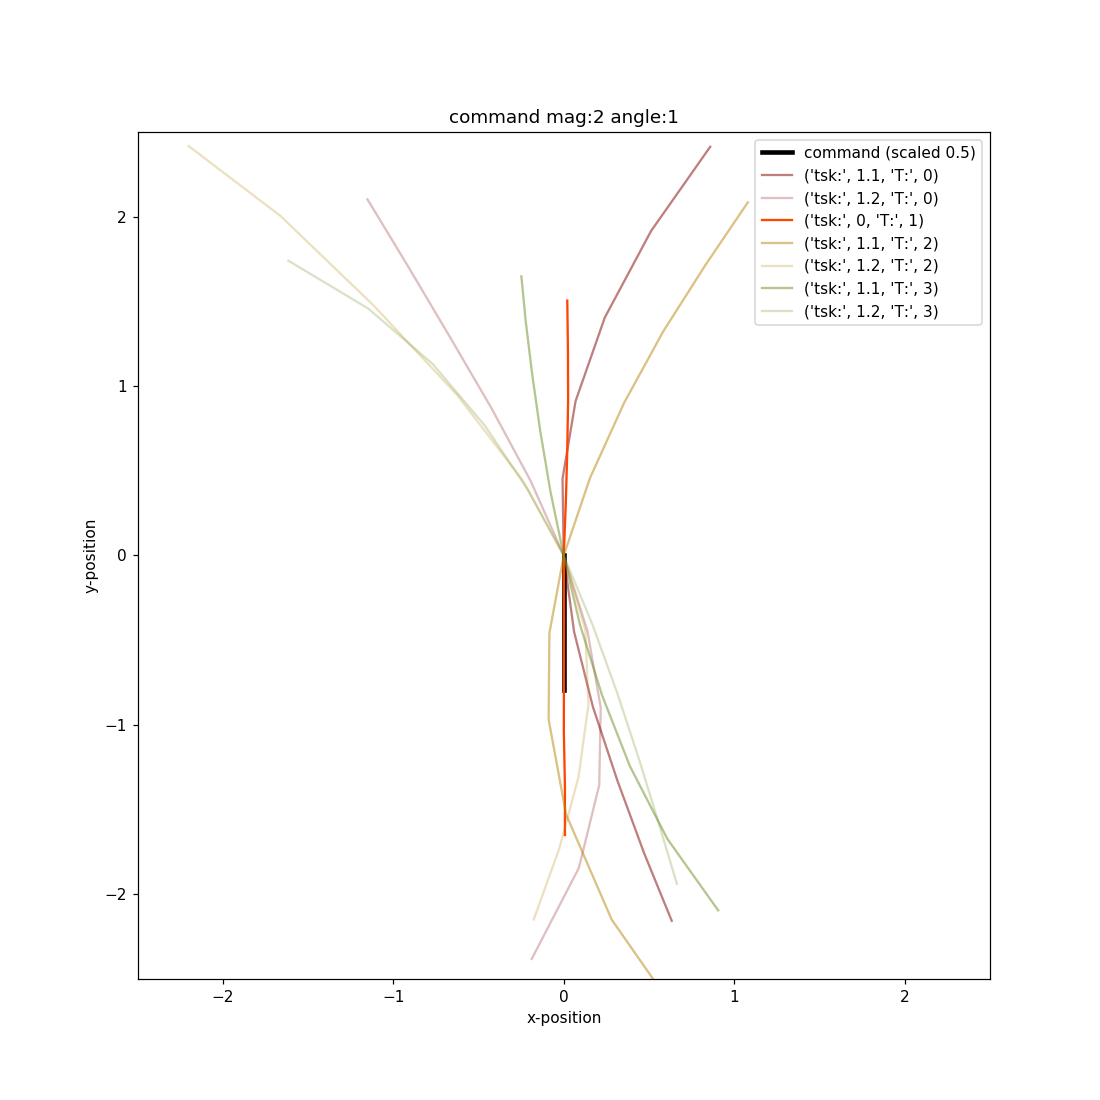

<IPython.core.display.Javascript object>


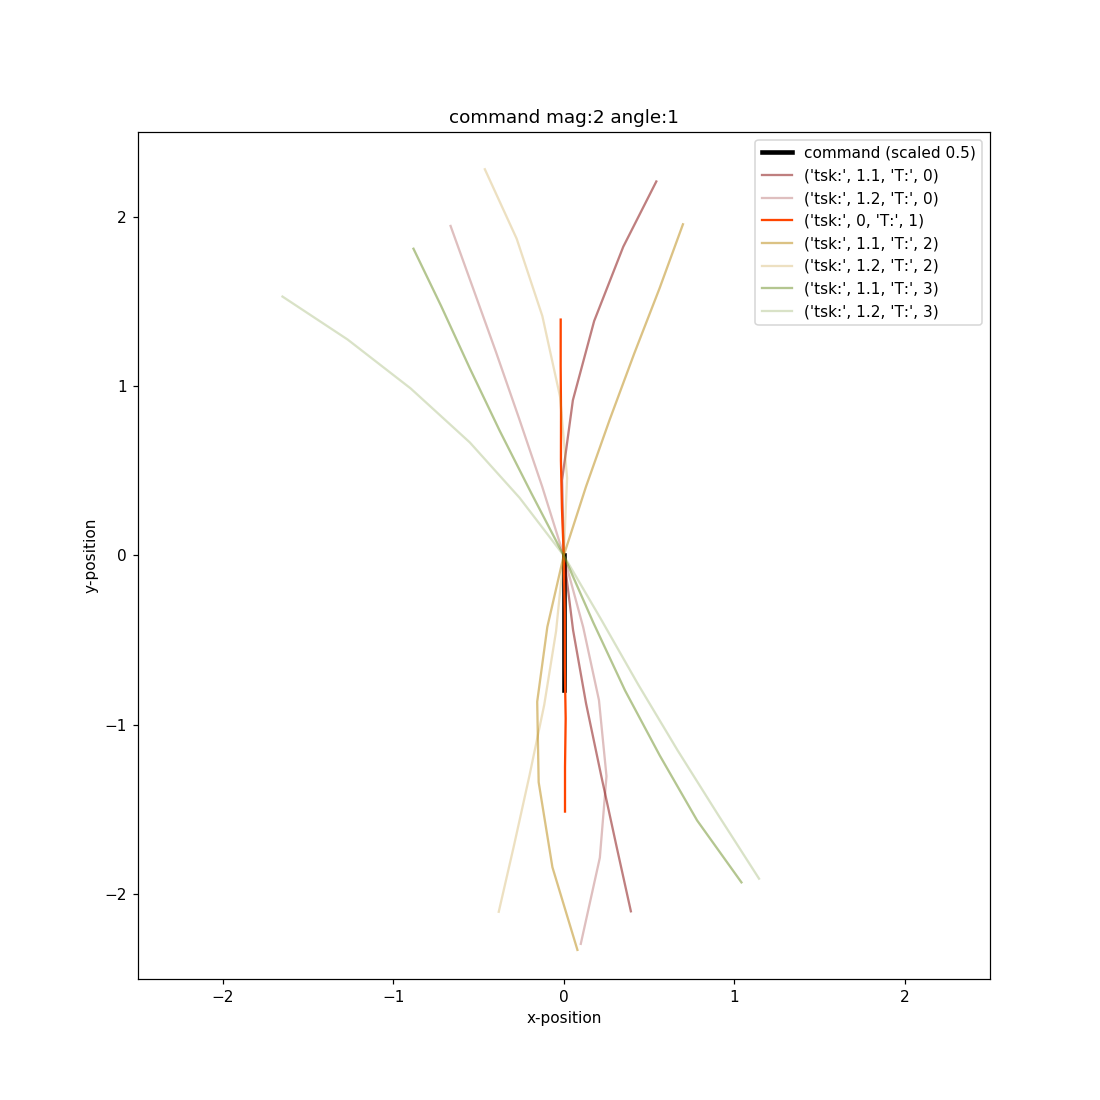

In [92]:
model_list = [('full', 'n_do'), ('full', 'n_o')]

save_bool = False
for model in model_list:
    fig_name = model[1]+'_command_locked_position_psth'
    psthc_list = psth_dic[model, 'psthc_list']

    mag_bin = c[0]
    angle_bin = c[1]
    sc = 0.5
    
    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc
    #print(x_bin, y_bin)
    
    task_alpha_dic = {0:1, 1.1:0.5, 1.2:0.25}   #[1, 0.5, 0.25]
    plt.figure(figsize=(10,10))
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')

    for i,psthc in enumerate(psthc_list):
        mv = m_for_c[i]
        task = mv[1] #int(round(m[1]))
        target = int(mv[0]) 

        plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '-', alpha=task_alpha_dic[task], color=target_color[target], label=('tsk:',task,'T:',target))
        #plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
        #plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  

    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    #plt.axis('equal')
    plt.legend()
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.title('command mag:'+str(mag_bin) + ' angle:' + str(angle_bin))

    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

### Population activity null distances

In [93]:
model_cm.keys()

[(('decoder_null', 'n_do'), (2, 4), (6, 1.1), 'cm_idx'),
 (('full', 'n_do'), (0, 4), (4, 0), 'n_diff_norm_mean', 's', 'null'),
 (('decoder_null', 'n_do'), (0, 7), (0, 1.2), 'n_diff', 'obs', 'null'),
 (('decoder_null', 'n_do'), (0, 5), (5, 1.1), 'n_diff_norm', 'obs', 'null'),
 (('full', 'n_o'), (3, 5), (6, 0), 'n_diff_norm_mean', 's', 'null'),
 (('full', 'n_do'), (1, 1), (5, 1.2), 'sel'),
 (('full', 'n_do'), (1, 5), (6, 1.1), 'n_diff', 's', 'null'),
 (('decoder_null', 'n_do'), (1, 2), (2, 1.2), 'num_obs'),
 (('full', 'n_o'), (3, 1), (6, 1.1), 'n_diff_norm_mean', 's', 'potent'),
 (('decoder_null', 'n_do'), (1, 7), (2, 1.2), 'n_diff_norm_std', 's', 'null'),
 (('decoder_null', 'n_do'), (2, 2), (1, 1.2), 'n_cm'),
 (('full', 'n_do'), (2, 6), (1, 1.2), 'pool_match_ttest'),
 (('decoder_null', 'n_do'), (2, 0), (7, 1.2), 'sel'),
 (('full', 'n_o'), (3, 4), (1, 0), 'n_diff_norm', 's', 'null'),
 (('decoder_null', 'n_o'), (0, 5), (6, 1.1), 'n_s'),
 (('decoder_null', 'n_do'), (0, 6), (3, 1.2), 'n_s')

In [ ]:
model_cm.keys()

In [94]:
model_cm[model, c, m, 'n_diff_norm', 'obs', 'null']

0.37187503124432764

In [95]:
model_cm[model, c, m, 'n_diff_norm', 's', 'null']

array([0.33192616, 0.33467753, 0.39625291, 0.39044436, 0.37789832,
       0.4606623 , 0.33477558, 0.42268743, 0.39565032, 0.32093906,
       0.37708071, 0.39585897, 0.36146975, 0.35314753, 0.34838101,
       0.3812367 , 0.32771762, 0.35681828, 0.30532057, 0.37791227,
       0.31186522, 0.29805291, 0.39832472, 0.32029149, 0.36044569,
       0.31303236, 0.41110413, 0.37721192, 0.4090296 , 0.31778321,
       0.322503  , 0.33731408, 0.32253921, 0.38460995, 0.31418713,
       0.33389721, 0.40932084, 0.32479609, 0.30075963, 0.3029202 ,
       0.41535018, 0.29139391, 0.35333968, 0.34992656, 0.36624818,
       0.32181902, 0.37104752, 0.31162782, 0.3553685 , 0.35186412,
       0.37944508, 0.43155462, 0.33399432, 0.31309847, 0.38213461,
       0.27989382, 0.36282298, 0.33088126, 0.486418  , 0.42665907,
       0.29703253, 0.36565402, 0.39297319, 0.38113485, 0.3850408 ,
       0.35400292, 0.42260078, 0.38702906, 0.31012109, 0.34945205,
       0.33265657, 0.39287379, 0.37252747, 0.26788536, 0.31657

In [97]:
type(model_cm[model, c, m, 'n_diff_norm', 's', 'null'])

numpy.ndarray

In [103]:
m

(3, 1.2)

In [127]:
m_for_c

[(0, 1.1), (0, 1.2), (1, 0), (2, 1.1), (2, 1.2), (3, 1.1), (3, 1.2)]

<IPython.core.display.Javascript object>


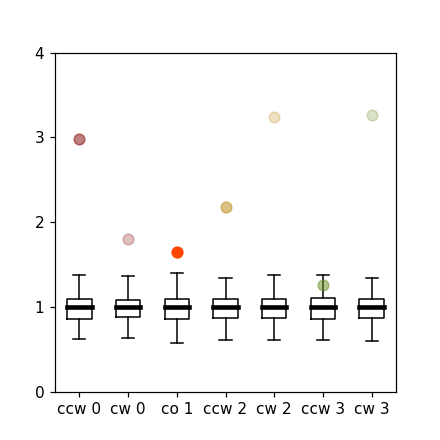

<IPython.core.display.Javascript object>


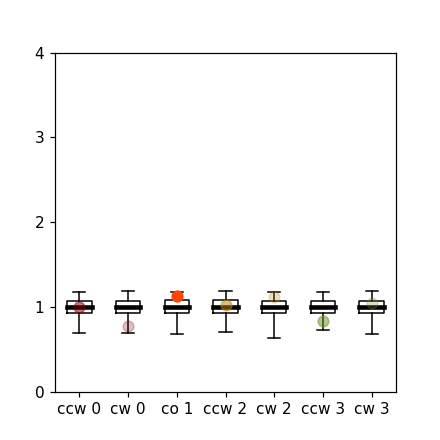

In [139]:
#Scatter plot of population distance

save_bool = True

model_list = [('full', 'n_do'), ('full', 'n_o')]
proj = 'null'

norm_by_shuffle = True

figsize=(4,4)
#Properties of box+whisker plot for shuffle:
medianprops=dict(linewidth=0)
meanprops=dict(linestyle='-',linewidth=3,color='k')
whis=[0,95]

# task_rot_list = [0,1.1,1.2]
# task_rot_label = ['co','obs_ccw', 'obs_cw']
task_code2str = {0:'co', 1.1:'ccw', 1.2: 'cw'}


for model in model_list:
    fig_name = model[1]+'_neural_command_diff'
    
    #Accumulate the obs and shuffle distances:
    obs_plot = []
    s_plot = []
    for i,m in enumerate(m_for_c): 
        s = model_cm[model, c, m, 'n_diff_norm', 's', proj]
        s_mean = np.mean(s)
        s_norm = s/s_mean
        
        if norm_by_shuffle:
            s_plot.append(s_norm)
        else:
            s_plot.append(s)
        
        
        obs = model_cm[model, c, m, 'n_diff_norm', 'obs', proj]
        obs_norm = obs/s_mean
        
        
        if norm_by_shuffle:
            obs_plot.append(obs_norm)
        else:
            obs_plot.append(obs)
        
    #Plot shuffle data
    fig,ax=plt.subplots(figsize=figsize)
    _=plt.boxplot(s_plot,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True

    #Plot observed data
    xtick_label = []
    for i,m in enumerate(m_for_c):
        #task = int(round(m[1]))
        task = m[1]
        task_str = task_code2str[task]
        target = int(m[0])    
        label = task_str+' '+str(target)
        xtick_label.append(label)
        plt.plot(i+1, obs_plot[i], '.', markersize=14, alpha=task_alpha_dic[task], color=target_color[target], label=label, zorder=1000)

    plt.ylim([0, 4])
    plt.yticks(range(5))
    num_move = len(m_for_c)
    plt.xticks(range(1,num_move+1),xtick_label)
    #plt.ylabel('Population distance (factor)')
    #plt.legend()
    
    
    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
whis=[5,95]
fig,ax=plt.subplots(figsize=figsize)
_=plt.boxplot(s_list,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True


In [96]:
m_for_c

[(0, 1.1), (0, 1.2), (1, 0), (2, 1.1), (2, 1.2), (3, 1.1), (3, 1.2)]